<a href="https://colab.research.google.com/github/cemsanga/MAT555E_Assignments/blob/main/HW4_CemS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cem Sanga - 509201104 - HW4 - MAT555E

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO
import requests
from collections import Counter
from os import path
from sklearn.model_selection import train_test_split
from scipy.stats import chisquare
from scipy.ndimage.interpolation import shift
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score,mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import xgboost as xgb
from keras.backend import clear_session
from math import sqrt

import tensorflow as tf
import keras as ks
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D,MaxPooling3D, LSTM, Embedding
from keras.utils import np_utils
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

# HW 4

# Q1

For this question we are going to use [1994 Census Adult Data Set](https://archive.ics.uci.edu/ml/datasets/adult).

Construct 

- Logistic regression
- SVM
- KNN
- Decision tree
- Gradient Boost (XGBoost)
- Neural network

models for the data. Cross-validate your models and measure the accuracies. Compare them putting the accuracies in a table.

## Data Handling

In [2]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',header=None)

I will take the column names from the file `adult.names` which was presented at the data source.

In [3]:
if path.exists("adult.names") == True:
    f = open('adult.names', "r")
    lines = f.readlines()
    descriptions = lines[-14:]
    col_names = []
    for x in descriptions:
        label = x.split(":")[0]
        col_names.append(label)
else:
    col_names=['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country']

We also need to add the target variable `income` to the columns

In [4]:
col_names.append("income")
col_names

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country',
 'income']

In [5]:
col_index = [i for i in range(len(col_names))]
col_dict = dict(zip(col_index,col_names))
origin_df = pd.DataFrame(data)
origin_df.rename(col_dict, axis=1, inplace = True)
df = origin_df
origin_df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [6]:
categorical = ["workclass", "education", "marital-status" , "occupation" , "relationship", "race", "sex", "native-country"]

Next, I will use a code snippet that I took from my classmate *Ahmet Süheyl Kiriş*. As we discussed in class, dealing with categorical data is problematic since every labeling we can do instead of the categories can be biased depending on the label type. So we give every option of a category an individual column. These new columns will only have binary values of $0$ or $1$, depending whether that row has that attribute. With my sincere gratitude to the owner, I name the snippet, _SuheylBinarizer_. (Later, we have noticed that LabelBinarizer does the same thing but it is still good for his citation count this way.)

The list `categorical values` only contains the columns of the dataset that has categorical parameters. At the end of the next code cell, `df` will be a DataFrame containing only the new binary columns.

In [7]:
# Süheyl Binarizer

trivial = np.zeros((32561,1)).astype(int)
df = pd.DataFrame(trivial, columns = ["Deneme"])

for a in range(len(categorical)):
    arr_unique = np.unique(data[categorical[a]])
    arr = data[categorical[a]]
    clmns = []
    
    for u in arr_unique:
        string = str(categorical[a]) + str(u)
        clmns.append(string)

    matrix = np.zeros((32561,len(arr_unique)))
    for i in range(len(arr_unique)):
        for j in range(32561):
            if arr[j] == arr_unique[i]:
                matrix[j][i] = 1;
    matrix = matrix.astype(int)
    df2 = pd.DataFrame(matrix, columns = clmns)
    df = df.join(df2)
df = df.drop(["Deneme"], axis=1)

Now I drop the original categorical columns from the initial `data` DataFrame and add the newly formed binary columns.

In [8]:
reduced_origin_df = origin_df.drop(categorical,axis = 1)
reduced_origin_df


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income
0,39,77516,13,2174,0,40,<=50K
1,50,83311,13,0,0,13,<=50K
2,38,215646,9,0,0,40,<=50K
3,53,234721,7,0,0,40,<=50K
4,28,338409,13,0,0,40,<=50K
...,...,...,...,...,...,...,...
32556,27,257302,12,0,0,38,<=50K
32557,40,154374,9,0,0,40,>50K
32558,58,151910,9,0,0,40,<=50K
32559,22,201490,9,0,0,20,<=50K


We need to join two dataframes by means of columns. Since the row indices are same, we can do this by `concat` function.

In [9]:
final_data = pd.concat([df,reduced_origin_df],axis = 1)

Using the helper function to convert the income column to binary values.

In [10]:
def helper(x):
    if ('<=' in x):
        return 0
    else:
        return 1
    
y = [helper(x) for x in data.iloc[:,14]]
final_data['income'] = y
final_data

,workclass ?,workclass Federal-gov,workclass Local-gov,workclass Never-worked,workclass Private,workclass Self-emp-inc,workclass Self-emp-not-inc,workclass State-gov,workclass Without-pay,education 10th,...,native-country United-States,native-country Vietnam,native-country Yugoslavia,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income
0,0,0,0,0,0,0,0,1,0,0,...,1,0,0,39,77516,13,2174,0,40,0
1,0,0,0,0,0,0,1,0,0,0,...,1,0,0,50,83311,13,0,0,13,0
2,0,0,0,0,1,0,0,0,0,0,...,1,0,0,38,215646,9,0,0,40,0
3,0,0,0,0,1,0,0,0,0,0,...,1,0,0,53,234721,7,0,0,40,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,28,338409,13,0,0,40,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0,0,0,0,1,0,0,0,0,0,...,1,0,0,27,257302,12,0,0,38,0
32557,0,0,0,0,1,0,0,0,0,0,...,1,0,0,40,154374,9,0,0,40,1
32558,0,0,0,0,1,0,0,0,0,0,...,1,0,0,58,151910,9,0,0,40,0
32559,0,0,0,0,1,0,0,0,0,0,...,1,0,0,22,201490,9,0,0,20,0


## Logistic Regression

Creating the Logistic regression model...

In [11]:
x = final_data.iloc[:,0:-1]
y = final_data.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.30)

LogResModel = LogisticRegression(C=1.0,penalty="l2",multi_class="multinomial",max_iter=10000,tol=1e-2,solver="newton-cg")
LogResModel.fit(x_train,y_train)
LogResPred = LogResModel.predict(x_test)

In [12]:
def LogResResults():
    print("Accuracy = ",accuracy_score(LogResPred,y_test))
    print("Confusion Matrix = \n",confusion_matrix(LogResPred,y_test))
LogResResults()
LogResScore = accuracy_score(LogResPred,y_test)

Accuracy =  0.8511618384686253
Confusion Matrix = 
 [[6935  922]
 [ 532 1380]]


## Support Vector Machine (SVM)

In [13]:
SVM_Model = SVC(C = 2, kernel="rbf",tol= 0.001,max_iter=20000)

SVM_Model.fit(x_train,y_train)
SVM_Pred = SVM_Model.predict(x_test)
def SVMResults():
    print("Accuracy = ",accuracy_score(SVM_Pred,y_test))
    print("Confusion Matrix = \n",confusion_matrix(SVM_Pred,y_test))
SVM_Score = accuracy_score(SVM_Pred,y_test)

In [14]:
SVMResults()

Accuracy =  0.7996724332070836
Confusion Matrix = 
 [[7448 1938]
 [  19  364]]


## K-Nearest Neighbor

In [15]:
KNN_scores = []
def KNN_Exp(N):
    global KNN_scores
    KNN_Model = KNeighborsClassifier(n_neighbors=N)
    KNN_Model.fit(x_train,y_train)
    KNN_Pred = KNN_Model.predict(x_test)
    KNN_scores.append(accuracy_score(KNN_Pred,y_test))
    print("Accuracy = ",accuracy_score(KNN_Pred,y_test))
    print("Confusion Matrix = \n",confusion_matrix(KNN_Pred,y_test))

In [16]:
for i in np.arange(2,12):
    print(i)
    KNN_Exp(i)

2
Accuracy =  0.7853413860169925
Confusion Matrix = 
 [[7080 1710]
 [ 387  592]]
3
Accuracy =  0.7549390930494421
Confusion Matrix = 
 [[6555 1482]
 [ 912  820]]
4
Accuracy =  0.7892312416828744
Confusion Matrix = 
 [[7131 1723]
 [ 336  579]]
5
Accuracy =  0.7764356638345787
Confusion Matrix = 
 [[6867 1584]
 [ 600  718]]
6
Accuracy =  0.7927116388576108
Confusion Matrix = 
 [[7201 1759]
 [ 266  543]]
7
Accuracy =  0.7838059166751971
Confusion Matrix = 
 [[7029 1674]
 [ 438  628]]
8
Accuracy =  0.7939400143310472
Confusion Matrix = 
 [[7243 1789]
 [ 224  513]]
9
Accuracy =  0.7904596171563107
Confusion Matrix = 
 [[7155 1735]
 [ 312  567]]
10
Accuracy =  0.7972156822602109
Confusion Matrix = 
 [[7289 1803]
 [ 178  499]]
11
Accuracy =  0.7938376497082609
Confusion Matrix = 
 [[7210 1757]
 [ 257  545]]


In [17]:
KNN_scores

[0.7853413860169925,
 0.7549390930494421,
 0.7892312416828744,
 0.7764356638345787,
 0.7927116388576108,
 0.7838059166751971,
 0.7939400143310472,
 0.7904596171563107,
 0.7972156822602109,
 0.7938376497082609]

Highest value is acquired by neighbors of 10. So, n is going to be 10.

## Decision Trees

In [18]:
DT_Model = DecisionTreeClassifier(max_depth=36, criterion="entropy")
DT_Model.fit(x,y)
DT_Score = DT_Model.score(x,y)
print(DT_Score)

0.9896501950185805


[Text(0.5072115384615384, 0.9166666666666666, 'X[27] <= 0.5\nentropy = 0.796\nsamples = 32561\nvalue = [24720, 7841]'),
 Text(0.25961538461538464, 0.75, 'X[105] <= 7073.5\nentropy = 0.348\nsamples = 17585\nvalue = [16436, 1149]'),
 Text(0.15384615384615385, 0.5833333333333334, 'X[104] <= 12.5\nentropy = 0.283\nsamples = 17274\nvalue = [16425, 849]'),
 Text(0.07692307692307693, 0.4166666666666667, 'X[102] <= 28.5\nentropy = 0.167\nsamples = 13864\nvalue = [13522, 342]'),
 Text(0.038461538461538464, 0.25, 'X[102] <= 21.5\nentropy = 0.043\nsamples = 6212\nvalue = [6183, 29]'),
 Text(0.019230769230769232, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.057692307692307696, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.11538461538461539, 0.25, 'X[107] <= 40.5\nentropy = 0.246\nsamples = 7652\nvalue = [7339, 313]'),
 Text(0.09615384615384616, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.1346153846153846, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.23076923076923078, 0.4166666666666667, '

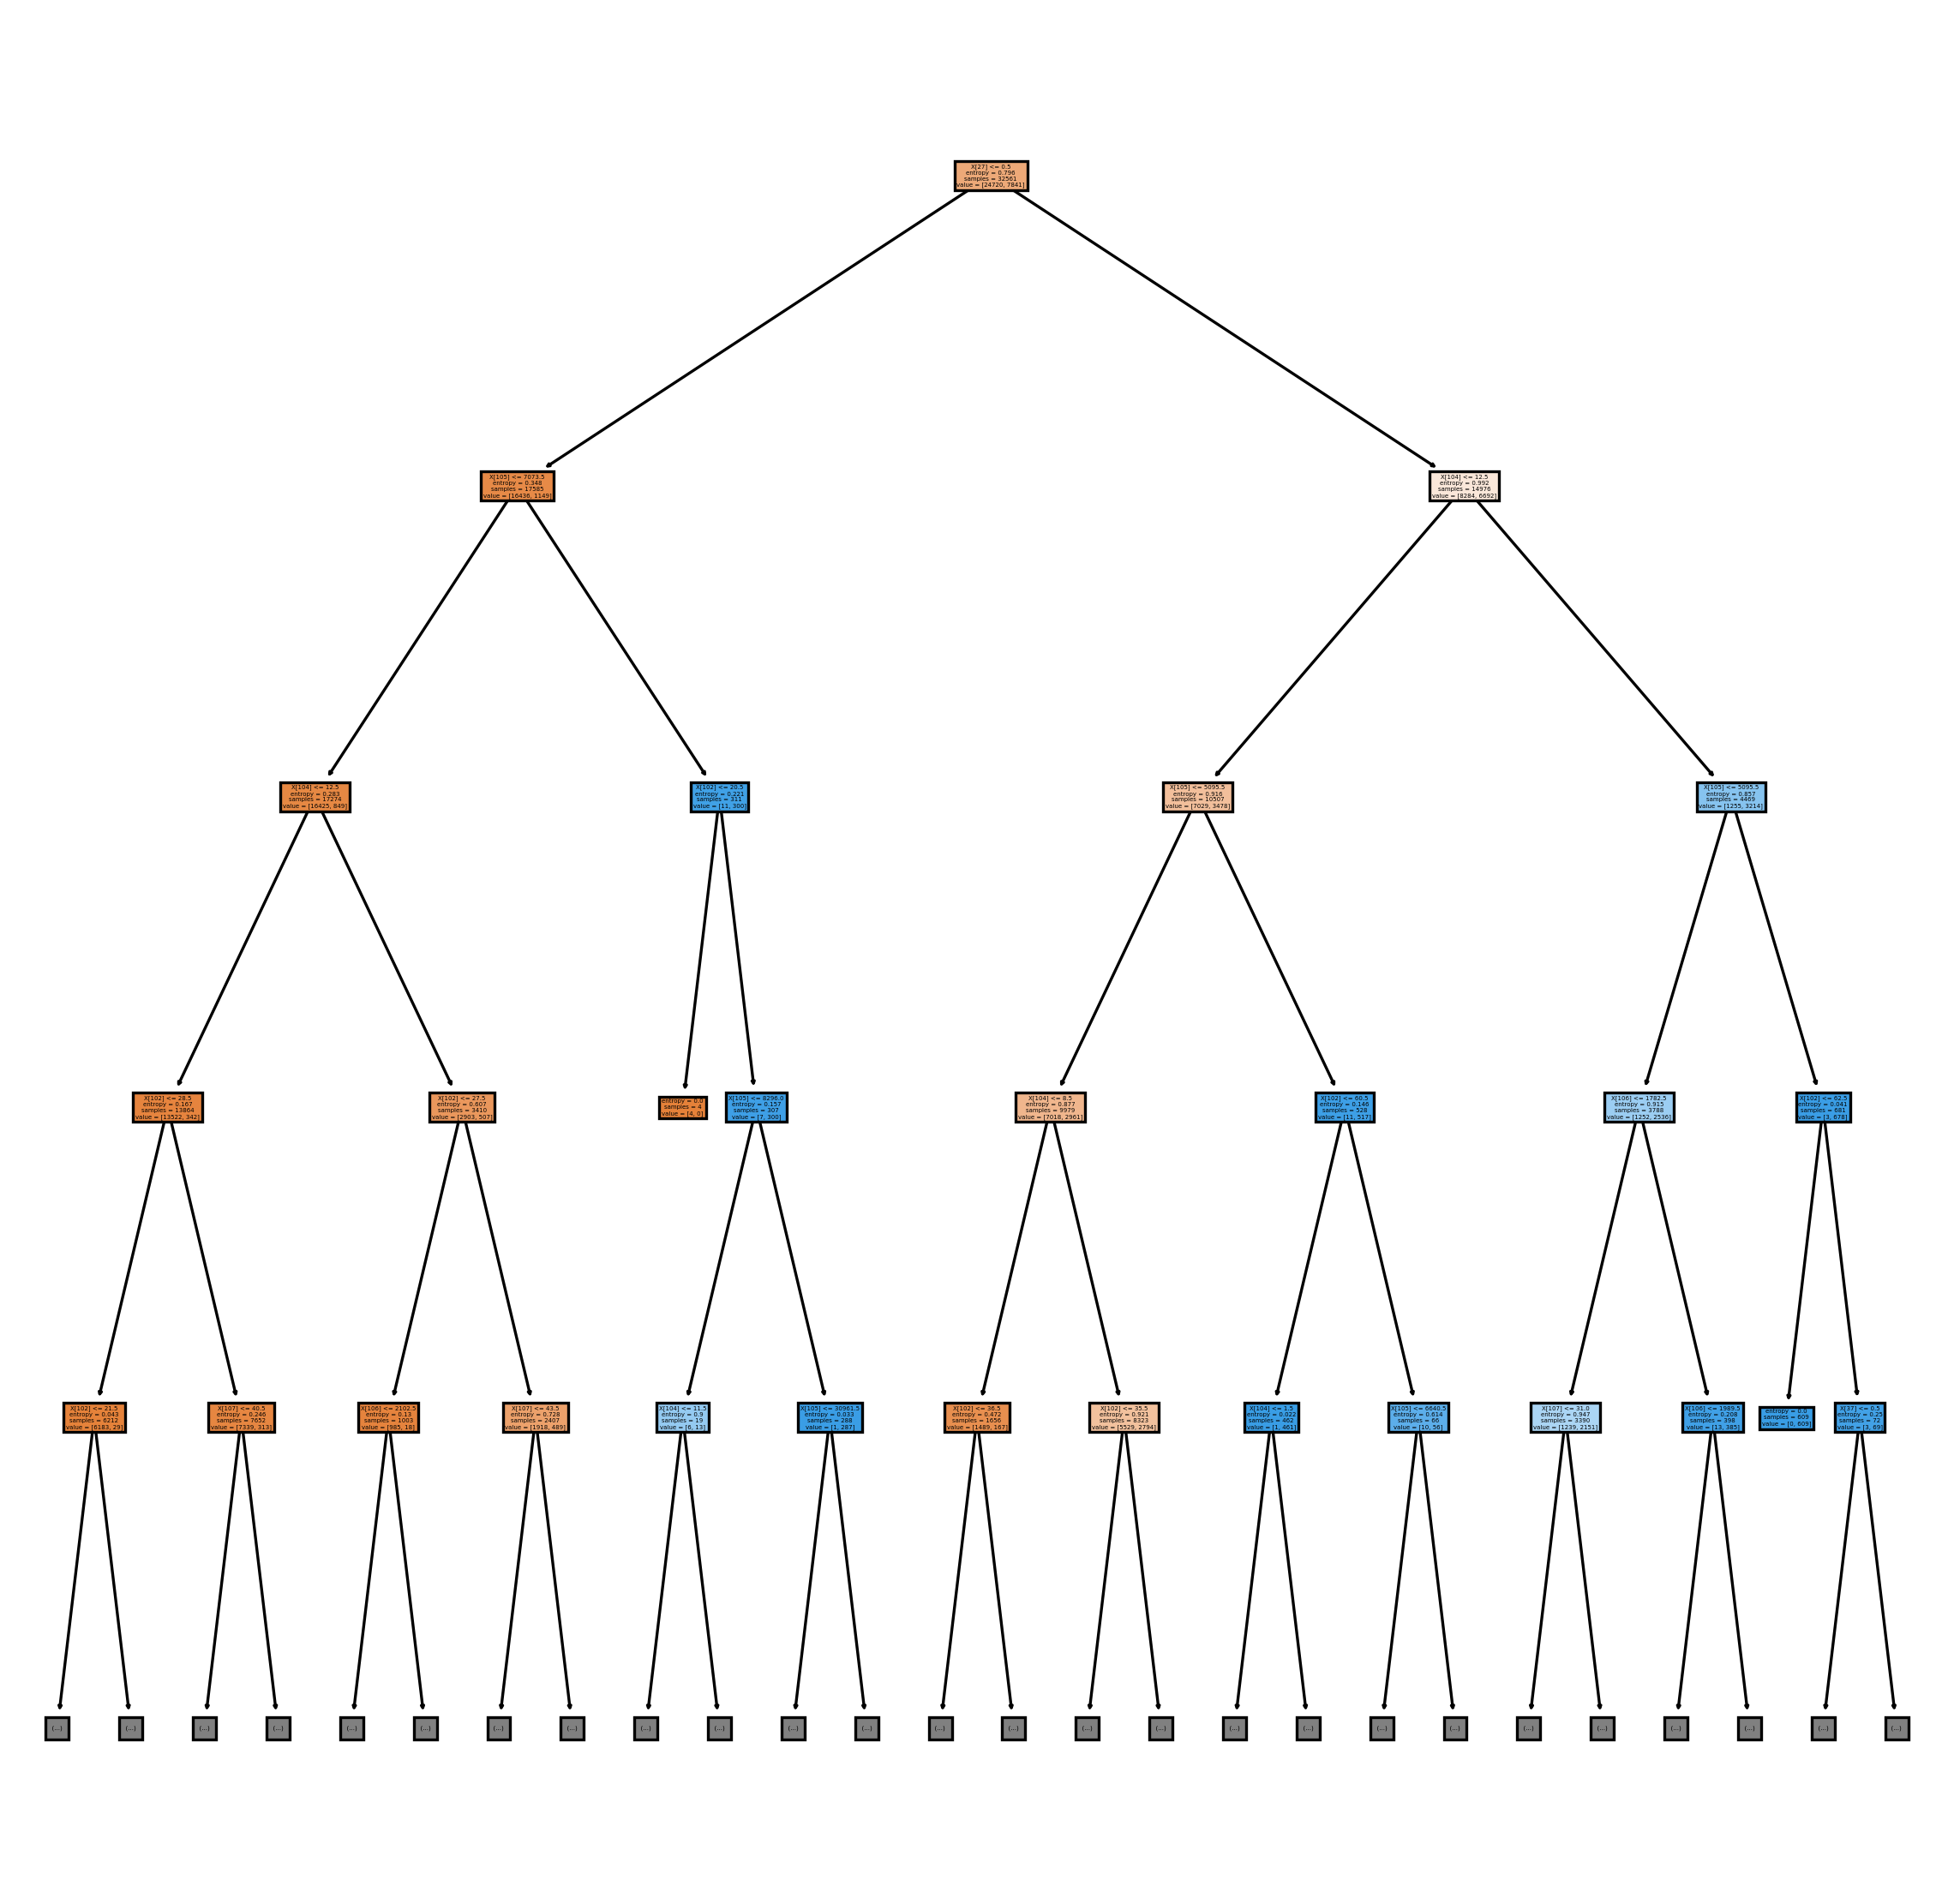

In [19]:
plt.figure(figsize=(12,12), dpi=240)
tree.plot_tree(DT_Model,filled = True,max_depth=4)

## XGBoost

In [20]:
XGB_Model = xgb.XGBClassifier()
XGB_Model.fit(x_train,y_train)
XGB_pred = XGB_Model.predict(x_test)
XGB_score = accuracy_score(XGB_pred,y_test)
print(XGB_score)


0.8639574163169209


## Neural Network

In [21]:
NN_model = ks.models.Sequential()

NN_model.add(ks.layers.Dense(100, activation='relu', input_dim=108))
NN_model.add(ks.layers.Dense(1,activation='sigmoid'))

In [22]:
NN_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

NN_model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['binary_accuracy'])

NN_model.fit(x_train,y_train,epochs=30,batch_size=100,validation_data=(x_test, y_test))
loss, accuracy = NN_model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, NN_score = NN_model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(NN_score))

Epoch 1/30
228/228 [==============================] - 1s 4ms/step - loss: 1555.5897 - binary_accuracy: 0.6467 - val_loss: 28.6452 - val_binary_accuracy: 0.7853
Epoch 2/30
228/228 [==============================] - 1s 3ms/step - loss: 89.2900 - binary_accuracy: 0.6858 - val_loss: 206.4037 - val_binary_accuracy: 0.2356
Epoch 3/30
228/228 [==============================] - 1s 3ms/step - loss: 103.9796 - binary_accuracy: 0.6854 - val_loss: 102.9348 - val_binary_accuracy: 0.7882
Epoch 4/30
228/228 [==============================] - 1s 3ms/step - loss: 89.7214 - binary_accuracy: 0.6853 - val_loss: 51.6180 - val_binary_accuracy: 0.7934
Epoch 5/30
228/228 [==============================] - 1s 3ms/step - loss: 97.2971 - binary_accuracy: 0.6913 - val_loss: 66.1345 - val_binary_accuracy: 0.7863
Epoch 6/30
228/228 [==============================] - 1s 3ms/step - loss: 52.4690 - binary_accuracy: 0.6891 - val_loss: 56.5880 - val_binary_accuracy: 0.2357
Epoch 7/30
228/228 [===========================

In [23]:
NN_model.summary()
clear_session()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               10900     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 11,001
Trainable params: 11,001
Non-trainable params: 0
_________________________________________________________________


## Q1 Results

In [24]:
Q1Res = pd.DataFrame()
Q1Res = Q1Res.append({"LogRes":LogResScore,"SVM":SVM_Score,"KNN":max(KNN_scores),"DT":DT_Score,"XGB":XGB_score,"NN":NN_score},ignore_index = True)
Q1Res.head()

,LogRes,SVM,KNN,DT,XGB,NN
0,0.851162,0.799672,0.797216,0.98965,0.863957,0.515406


The winner seems like the Decision Tree Classifier.

# Q2

For this question we are going to use [the Dry Bean Dataset](https://archive.ics.uci.edu/ml/datasets/Dry+Bean+Dataset):

Construct 

- Logistic regression
- SVM
- KNN
- Decision tree
- Gradient Boost (XGBoost)
- Neural network

models for the data. Cross-validate your models and measure the accuracies. Compare them putting the accuracies in a table.

## Data Handling

In [25]:
with urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/00602/DryBeanDataset.zip') as url:
    zf = ZipFile(BytesIO(url.read()))
    data = pd.read_excel(zf.open('DryBeanDataset/Dry_Bean_Dataset.xlsx'))
    
data

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,42097,759.696,288.721612,185.944705,1.552728,0.765002,42508,231.515799,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,DERMASON
13607,42101,757.499,281.576392,190.713136,1.476439,0.735702,42494,231.526798,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,DERMASON
13608,42139,759.321,281.539928,191.187979,1.472582,0.734065,42569,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,DERMASON
13609,42147,763.779,283.382636,190.275731,1.489326,0.741055,42667,231.653248,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,DERMASON


Doing the same process to the outcomes as above. This time, instead of income, we have several classes so we need to use several labels.

In [26]:
le = LabelEncoder()
data['Class'] = le.fit_transform(data['Class'])
data['Class']

0        5
1        5
2        5
3        5
4        5
        ..
13606    3
13607    3
13608    3
13609    3
13610    3
Name: Class, Length: 13611, dtype: int64

In [27]:
x2 = data.iloc[:,0:-1]
y2 = data.iloc[:,-1]

## Logistic Regression

In [28]:
x2_train, x2_test, y2_train, y2_test = train_test_split(x2,y2,test_size=0.30)

LogResModel2 = LogisticRegression(C=1.0,solver="lbfgs",multi_class="multinomial",max_iter=10000,tol=1e-1)
LogResModel2.fit(x2_train,y2_train)
LogResPred2 = LogResModel2.predict(x2_test)

def LogResResults2():
    print("Accuracy = ",accuracy_score(LogResPred2,y2_test))
    print("Confusion Matrix = \n",confusion_matrix(LogResPred2,y2_test))
LogResResults2()
LogResScore2 = accuracy_score(LogResPred2,y2_test)

Accuracy =  0.9106268364348677
Confusion Matrix = 
 [[361   0  19   0   2   1   4]
 [  0 159   0   0   0   0   0]
 [ 33   0 422   0  10   1   3]
 [  0   0   0 958   9  16  79]
 [  4   0  13   2 519   1  13]
 [  3   0   1  17   0 592  15]
 [  8   0   6  69  10  26 708]]


## Support Vector Machine

In [29]:
SVM_Model2 = SVC(C = 2, kernel="rbf",tol= 0.001,max_iter=20000)

SVM_Model2.fit(x2_train,y2_train)
SVM_Pred2 = SVM_Model2.predict(x2_test)
def SVMResults():
    print("Accuracy = ",accuracy_score(SVM_Pred2,y2_test))
    print("Confusion Matrix = \n",confusion_matrix(SVM_Pred2,y2_test))
SVM_Score2 = accuracy_score(SVM_Pred2,y2_test)

## K-Nearest Neighbor

In [30]:
KNN_scores2 = []
def KNN_Exp(N):
    global KNN_scores2
    KNN_Model2 = KNeighborsClassifier(n_neighbors=N)
    KNN_Model2.fit(x2_train,y2_train)
    KNN_Pred2 = KNN_Model2.predict(x2_test)
    KNN_scores2.append(accuracy_score(KNN_Pred2,y2_test))
    print("Accuracy = ",accuracy_score(KNN_Pred2,y2_test))
    print("Confusion Matrix = \n",confusion_matrix(KNN_Pred2,y2_test))
  
for i in np.arange(2,12):
    print(i)
    KNN_Exp(i)

2
Accuracy =  0.6914789422135161
Confusion Matrix = 
 [[277   0 223   0  68   2  22]
 [  1 159   1   0   0   0   0]
 [102   0 222   0  51   1   5]
 [  0   0   0 966  28 182 158]
 [ 18   0  13   7 369  11 104]
 [  2   0   1  47   3 386  88]
 [  9   0   1  26  31  55 445]]
3
Accuracy =  0.713026444662096
Confusion Matrix = 
 [[196   0 127   0  47   0  14]
 [  0 159   0   0   0   0   0]
 [162   0 301   0  27   1   7]
 [  0   0   0 918  24 135 118]
 [ 39   0  31   4 368   9  69]
 [  0   0   1  62   1 398  42]
 [ 12   0   1  62  83  94 572]]
4
Accuracy =  0.7115572967678746
Confusion Matrix = 
 [[242   0 178   0  41   0  11]
 [  1 159   1   0   0   0   0]
 [119   0 251   0  35   0   0]
 [  0   0   0 941  23 146 111]
 [ 38   0  29   2 382  11  92]
 [  0   0   1  50   1 390  67]
 [  9   0   1  53  68  90 541]]
5
Accuracy =  0.713026444662096
Confusion Matrix = 
 [[199   0 126   0  42   0   7]
 [  0 159   0   0   0   0   0]
 [150   0 307   0  24   0   0]
 [  0   0   0 925  26 142 109]
 [ 49   

## Decision Tree

In [31]:
DT_Model2 = DecisionTreeClassifier(max_depth=36, criterion="entropy")
DT_Model2.fit(x2,y2)
DT_Score2 = DT_Model2.score(x2,y2)
print(DT_Score2)

1.0


[Text(0.5145833333333333, 0.9166666666666666, 'X[2] <= 328.881\nentropy = 2.647\nsamples = 13611\nvalue = [1322, 522, 1630, 3546, 1928, 2027, 2636]'),
 Text(0.26666666666666666, 0.75, 'X[3] <= 181.384\nentropy = 1.753\nsamples = 8298\nvalue = [136, 0, 7, 3546, 156, 2023, 2430]'),
 Text(0.13333333333333333, 0.5833333333333334, 'X[1] <= 704.897\nentropy = 0.755\nsamples = 3695\nvalue = [1, 0, 0, 3151, 141, 17, 385]'),
 Text(0.06666666666666667, 0.4166666666666667, 'X[1] <= 668.069\nentropy = 0.169\nsamples = 2708\nvalue = [0, 0, 0, 2653, 5, 16, 34]'),
 Text(0.03333333333333333, 0.25, 'X[12] <= 0.007\nentropy = 0.048\nsamples = 1873\nvalue = [0, 0, 0, 1863, 0, 10, 0]'),
 Text(0.016666666666666666, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.05, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.1, 0.25, 'X[4] <= 1.403\nentropy = 0.359\nsamples = 835\nvalue = [0, 0, 0, 790, 5, 6, 34]'),
 Text(0.08333333333333333, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.11666666666666667, 0.0833333333

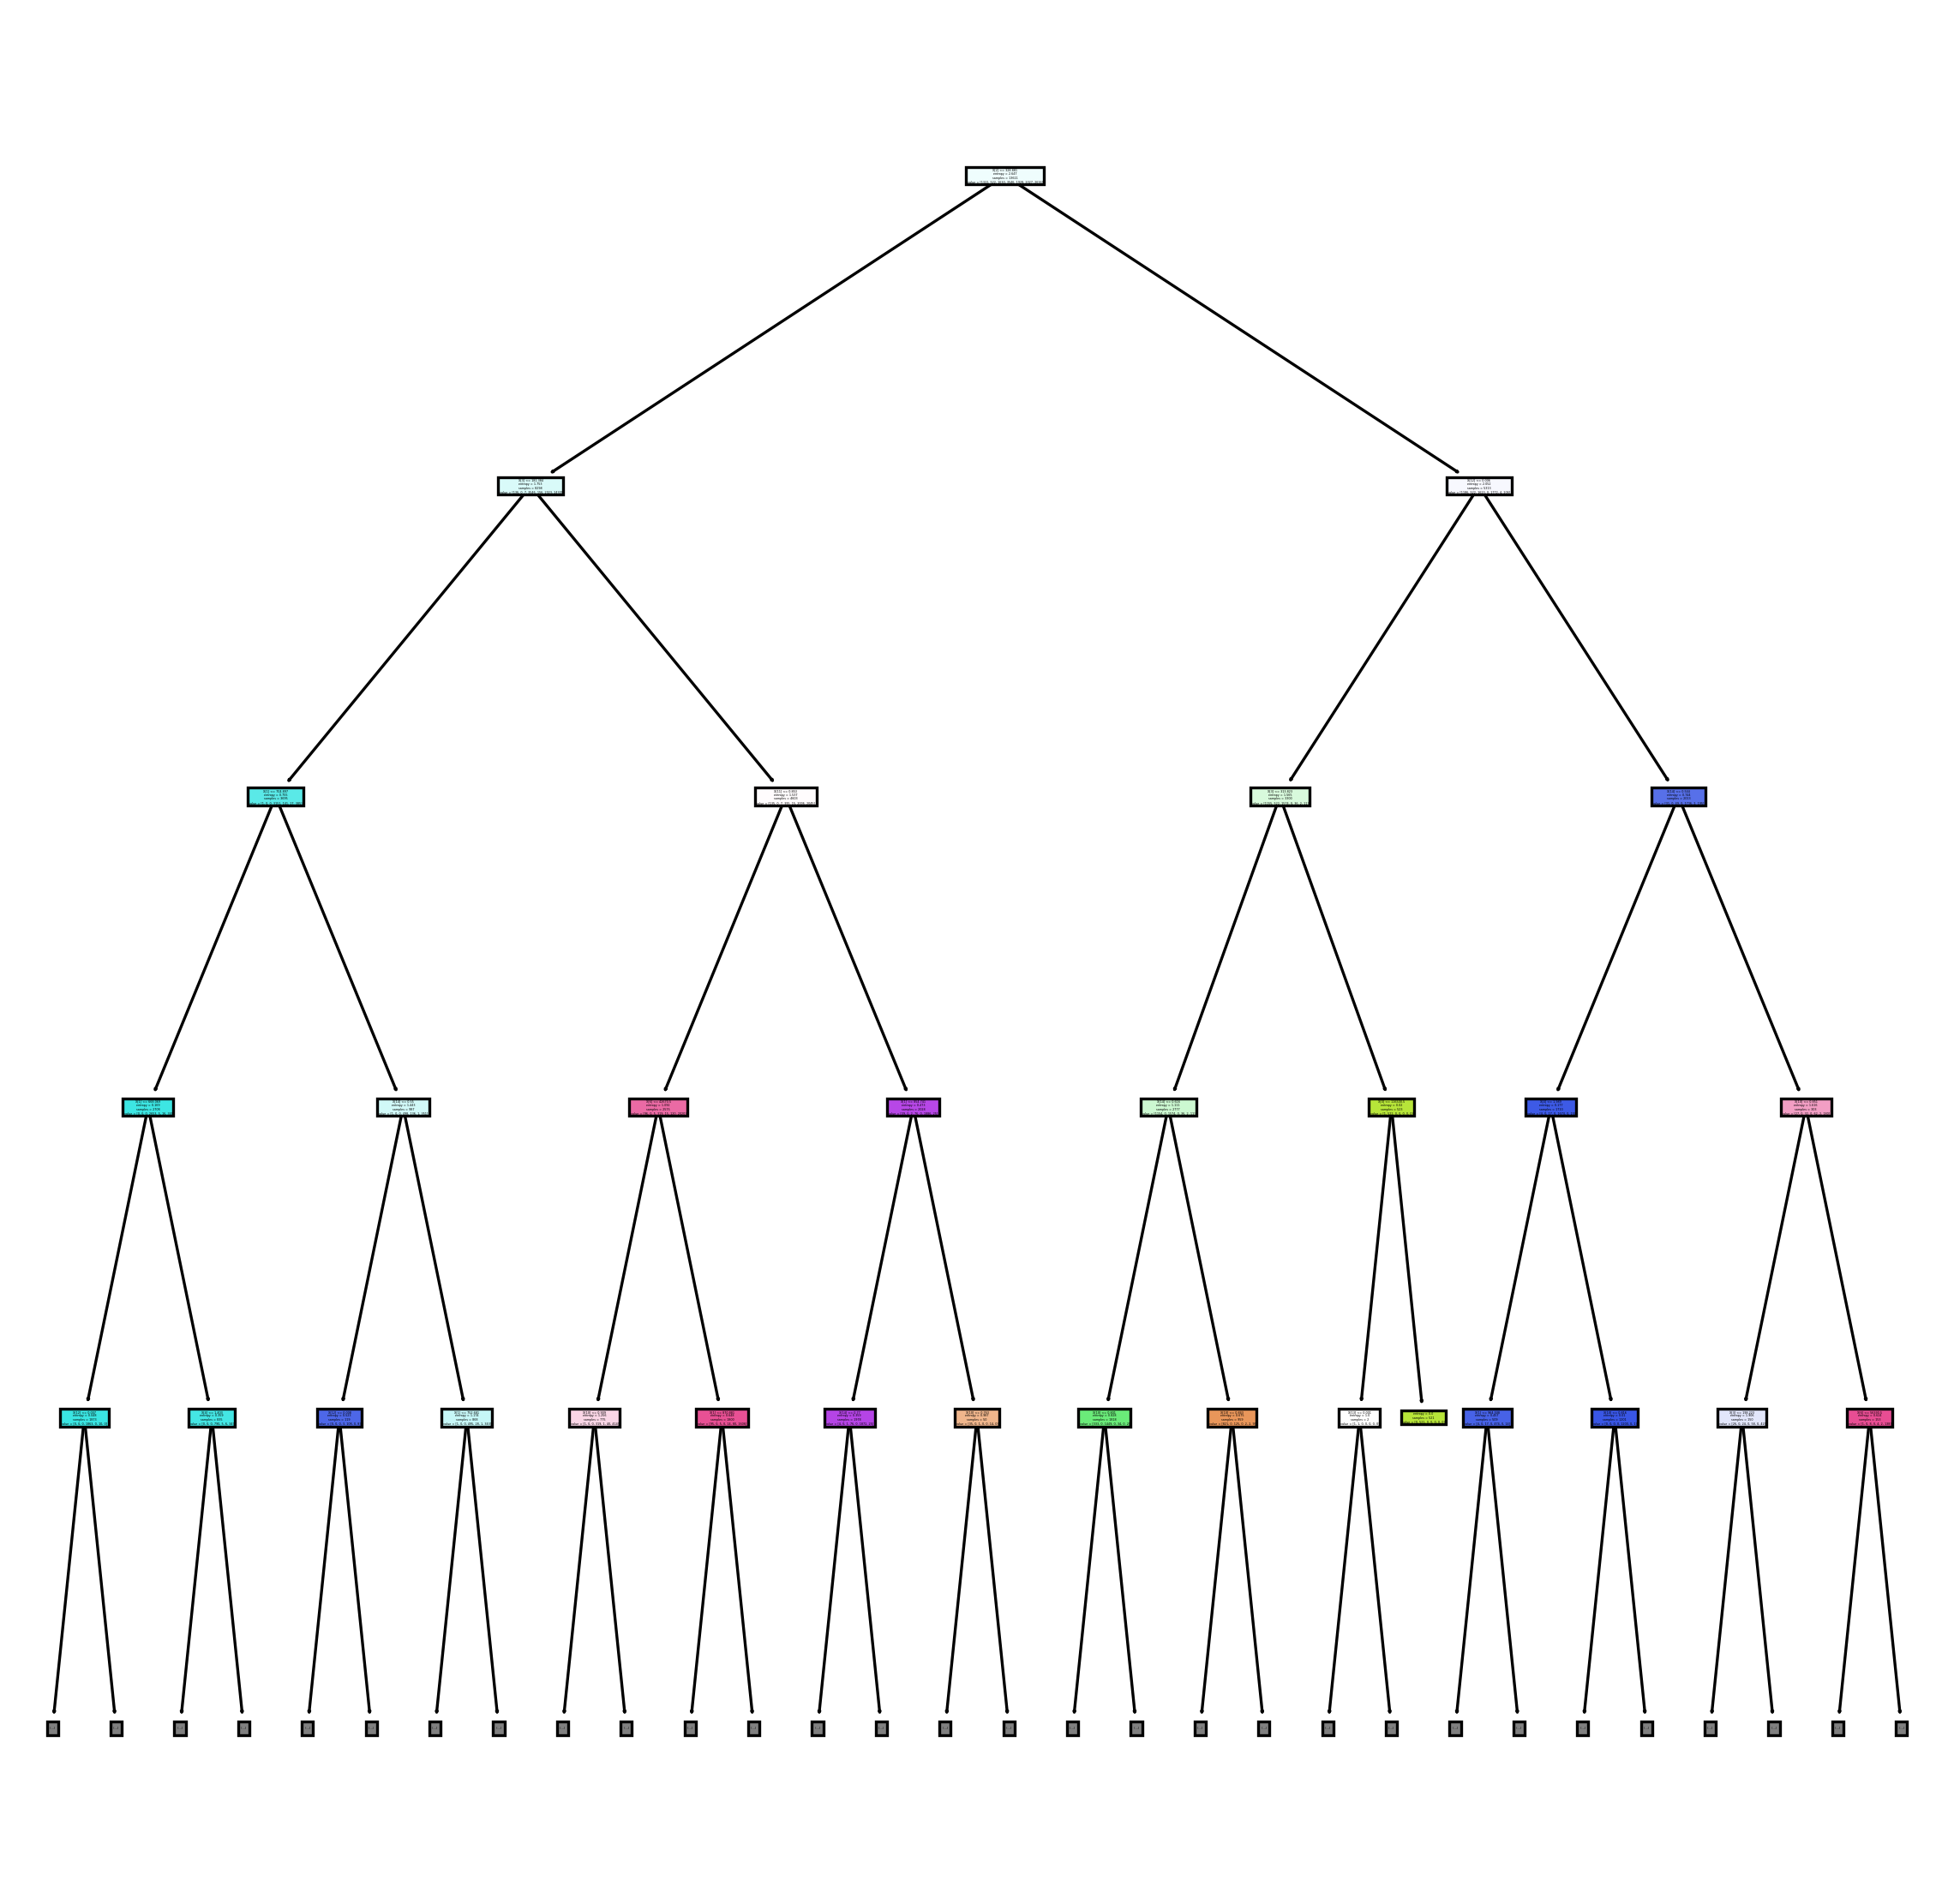

In [32]:
plt.figure(figsize=(12,12), dpi=240)
tree.plot_tree(DT_Model2,filled = True,max_depth=4)

## XGBoost

In [33]:
XGB_Model2 = xgb.XGBClassifier()
XGB_Model2.fit(x2_train,y2_train)
XGB_pred2 = XGB_Model2.predict(x2_test)
XGB_score2 = accuracy_score(XGB_pred2,y2_test)
print(XGB_score2)

0.9248285994123409


## Neural Network

In [34]:
NN_model2 = ks.models.Sequential()

NN_model2.add(ks.layers.Dense(100, activation='relu', input_dim=16))
NN_model2.add(ks.layers.Dense(25,activation='relu'))
NN_model2.add(ks.layers.Dense(1,activation='softmax'))

NN_model2.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['binary_accuracy'])

NN_model2.fit(x2_train,y2_train,epochs=30,batch_size=100,validation_data=(x2_test, y2_test))
loss2, accuracy2 = NN_model2.evaluate(x2_train, y2_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy2))
loss2, NN_score2 = NN_model2.evaluate(x2_test, y2_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(NN_score2))

Epoch 1/30
96/96 [==============================] - 1s 6ms/step - loss: -91282.7578 - binary_accuracy: 0.0381 - val_loss: -276021.6250 - val_binary_accuracy: 0.0389
Epoch 2/30
96/96 [==============================] - 0s 3ms/step - loss: -905063.2500 - binary_accuracy: 0.0381 - val_loss: -1998026.6250 - val_binary_accuracy: 0.0389
Epoch 3/30
96/96 [==============================] - 0s 3ms/step - loss: -4162175.7500 - binary_accuracy: 0.0381 - val_loss: -7230971.5000 - val_binary_accuracy: 0.0389
Epoch 4/30
96/96 [==============================] - 0s 3ms/step - loss: -11801645.0000 - binary_accuracy: 0.0381 - val_loss: -17825938.0000 - val_binary_accuracy: 0.0389
Epoch 5/30
96/96 [==============================] - 0s 3ms/step - loss: -25611856.0000 - binary_accuracy: 0.0381 - val_loss: -35417040.0000 - val_binary_accuracy: 0.0389
Epoch 6/30
96/96 [==============================] - 0s 3ms/step - loss: -47190636.0000 - binary_accuracy: 0.0381 - val_loss: -61599524.0000 - val_binary_accurac

## Q2 Results

In [35]:
Q2Res = pd.DataFrame()
Q2Res = Q2Res.append({"LogRes":LogResScore2,"SVM":SVM_Score2,"KNN":max(KNN_scores2),"DT":DT_Score2,"XGB":XGB_score2,"NN":NN_score2},ignore_index = True)
Q2Res.head()

,LogRes,SVM,KNN,DT,XGB,NN
0,0.910627,0.622919,0.713026,1.0,0.924829,0.038932


The winner seems like, again, the Decision Tree Classifier.

# Q3

For this question we are going to use the [Japanese MNIST](https://github.com/rois-codh/kmnist) dataset.

Construct a convolutional neural network model for the dataset and cross-validate your model.

In [36]:
try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x, total, unit: x  # If tqdm doesn't exist, replace it with a function that does nothing
    print('**** Could not import tqdm. Please install tqdm for download progressbars! (pip install tqdm) ****')

# Python2 compatibility
try:
    input = raw_input
except NameError:
    pass

download_dict = {
    '1) Kuzushiji-MNIST (10 classes, 28x28, 70k examples)': {
        '1) MNIST data format (ubyte.gz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-images-idx3-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-labels-idx1-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-images-idx3-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-labels-idx1-ubyte.gz'],
        '2) NumPy data format (.npz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz'],
    },
    '2) Kuzushiji-49 (49 classes, 28x28, 270k examples)': {
        '1) NumPy data format (.npz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz'],
    },
    '3) Kuzushiji-Kanji (3832 classes, 64x64, 140k examples)': {
        '1) Folders of images (.tar)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kkanji/kkanji.tar'],
    }

}

# Download a list of files
def download_list(url_list):
    for url in url_list:
        path = url.split('/')[-1]
        r = requests.get(url, stream=True)
        with open(path, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            print('Downloading {} - {:.1f} MB'.format(path, (total_length / 1024000)))

            for chunk in tqdm(r.iter_content(chunk_size=1024), total=int(total_length / 1024) + 1, unit="KB"):
                if chunk:
                    f.write(chunk)
    print('All dataset files downloaded!')

# Ask the user about which path to take down the dict
def traverse_dict(d):
    print('Please select a download option:')
    keys = sorted(d.keys())  # Print download options
    for key in keys:
        print(key)

    userinput = input('> ').strip()

    try:
        selection = int(userinput) - 1
    except ValueError:
        print('Your selection was not valid')
        traverse_dict(d)  # Try again if input was not valid
        return

    selected = keys[selection]

    next_level = d[selected]
    if isinstance(next_level, list):  # If we've hit a list of downloads, download that list
        download_list(next_level)
    else:
        traverse_dict(next_level)     # Otherwise, repeat with the next level

traverse_dict(download_dict)

Please select a download option:
1) Kuzushiji-MNIST (10 classes, 28x28, 70k examples)
2) Kuzushiji-49 (49 classes, 28x28, 270k examples)
3) Kuzushiji-Kanji (3832 classes, 64x64, 140k examples)
> 1
Please select a download option:
1) MNIST data format (ubyte.gz)
2) NumPy data format (.npz)
> 2


100%|██████████| 17954/17954 [00:05<00:00, 3081.13KB/s]


100%|██████████| 30/30 [00:00<00:00, 814.61KB/s]


100%|██████████| 3008/3008 [00:01<00:00, 2410.67KB/s]


100%|██████████| 6/6 [00:00<00:00, 8286.41KB/s]

All dataset files downloaded!


In [37]:
CHAR_PATH = "http://codh.rois.ac.jp/kmnist/dataset/kmnist/"
char_df = pd.read_csv(CHAR_PATH+'kmnist_classmap.csv', encoding = 'utf-8')
x3_train = np.load('kmnist-train-imgs.npz')['arr_0']
x3_test = np.load('kmnist-test-imgs.npz')['arr_0']
y3_train = np.load('kmnist-train-labels.npz')['arr_0']
y3_test = np.load('kmnist-test-labels.npz')['arr_0']

x3_train.shape,x3_test.shape

((60000, 28, 28), (10000, 28, 28))

In [38]:
char_df

,index,codepoint,char
0,0,U+304A,お
1,1,U+304D,き
2,2,U+3059,す
3,3,U+3064,つ
4,4,U+306A,な
5,5,U+306F,は
6,6,U+307E,ま
7,7,U+3084,や
8,8,U+308C,れ
9,9,U+3092,を


In [39]:
x3_train.reshape(60000,28,28,1)
x3_test.reshape(10000,28,28,1)
x3_train.shape,x3_test.shape

((60000, 28, 28), (10000, 28, 28))

In [40]:
y3_train.shape

(60000,)

In [41]:
y3_train_cat = to_categorical(y3_train)
y3_test_cat = to_categorical(y3_test)

In [42]:
y3_train_cat.shape

(60000, 10)

In [43]:
model3 = ks.models.Sequential()

model3.add(Conv2D(64, (3, 3), padding="same", activation='relu', input_shape=(28,28,1)))
model3.add(MaxPooling2D((3,3)))
model3.add(Flatten())
model3.add(Dense(128, activation = 'relu',))
model3.add(Dense(10, activation = 'softmax'))

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

model3.fit(x3_train, y3_train_cat, batch_size=64, epochs=5)

Epoch 1/5
938/938 [==============================] - 45s 47ms/step - loss: 0.2052 - binary_accuracy: 0.9807
Epoch 2/5
938/938 [==============================] - 46s 49ms/step - loss: 0.0255 - binary_accuracy: 0.9939
Epoch 3/5
938/938 [==============================] - 40s 42ms/step - loss: 0.0169 - binary_accuracy: 0.9962
Epoch 4/5
938/938 [==============================] - 41s 44ms/step - loss: 0.0128 - binary_accuracy: 0.9973
Epoch 5/5
938/938 [==============================] - 38s 41ms/step - loss: 0.0107 - binary_accuracy: 0.9977


In [44]:
loss3, accuracy3 = model3.evaluate(x3_train, y3_train_cat, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy3))
loss3, NN_score3 = model3.evaluate(x3_test, y3_test_cat, verbose=False)
print("Testing Accuracy:  {:.4f}".format(NN_score3))

Training Accuracy: 0.9987
Testing Accuracy:  0.9864


# Q4

For this question we are going to use Box and Jenkins Airline Passenger Dataset. For this dataset, please install the `rdatasets` library:

In [45]:
!pip install rdatasets
from rdatasets import data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Construct

- recurrent 
- LSTM

neutral network models on the train set (the first 122 values), and then test it on the last 24 values.

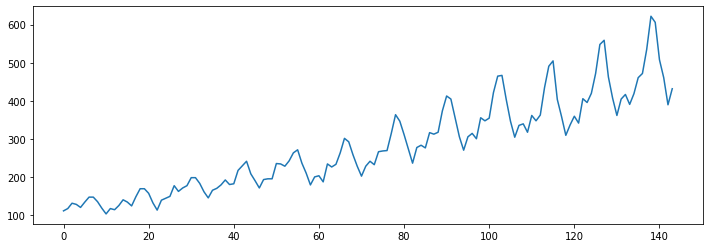

In [46]:
airline = data('AirPassengers')

plt.figure(figsize=(12,4))
airline['value'].plot()

In [47]:
train = airline[:123]
test = airline[123:]
print(train[1:5])
print(test[1:5])

          time  value
1  1949.083333    118
2  1949.166667    132
3  1949.250000    129
4  1949.333333    121
            time  value
124  1959.333333    420
125  1959.416667    472
126  1959.500000    548
127  1959.583333    559


In [48]:
time_df = airline['time']
value_df = airline['value']
value = value_df.to_numpy()
time = time_df.to_numpy()
value[0:4],time[0:4]

(array([112, 118, 132, 129]),
 array([1949.        , 1949.08333333, 1949.16666667, 1949.25      ]))

On the web, I generally read that scaling this problem's set using maximum and minimum values for this problem is a good thing. So here it is.

In [49]:
scale = MinMaxScaler(feature_range=(0, 1))
time = scale.fit_transform(time.reshape(-1,1))
value = scale.fit_transform(value.reshape(-1,1))
print(value[0:4])
print("\n")
print(time[0:4])

[[0.01544402]
 [0.02702703]
 [0.05405405]
 [0.04826255]]


[[0.        ]
 [0.00699301]
 [0.01398601]
 [0.02097902]]


The training data set must be separated into pieces so that the pieces must be following each other like the i_th data on the one set must be the same of the i+1_th data on the other set. So one follows the other one from 1 step back.

In [50]:
shifted_value = np.roll(value, -1)
print(value[0:4])
print("\n")
print(shifted_value[0:4])

[[0.01544402]
 [0.02702703]
 [0.05405405]
 [0.04826255]]


[[0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]]


In [51]:
shifted_value[-5:] # Last 5 elements

array([[0.77992278],
       [0.68918919],
       [0.55212355],
       [0.63320463],
       [0.01544402]])

I drop the last elements so the continuity of the time series is provided and they are of equal size.

In [52]:
v = value[:-1]
sv = shifted_value[:-1]
v.size,sv.size

(143, 143)

Doing the same thing for time set.

In [53]:
shifted_time = np.roll(time, -1)
t = time[:-1]
st = shifted_time[:-1]
t.size,st.size

(143, 143)

In [54]:
print(time[0:4])
print("\n")
print(shifted_time[0:4])

[[0.        ]
 [0.00699301]
 [0.01398601]
 [0.02097902]]


[[0.00699301]
 [0.01398601]
 [0.02097902]
 [0.02797203]]


In [55]:
v_train = v[:120]
v_test = v[120:]
t_train = t[:120]
t_test = t[120:]
v_train.shape,v_test.shape,t_train.shape,t_test.shape

((120, 1), (23, 1), (120, 1), (23, 1))

`inputs: A 3D tensor with shape [batch, timesteps, feature].` 

This is from `LSTM` function documentation at tensorflow.keras.layers

In [56]:
trainX = np.reshape(t_train,(t_train.shape[0],1,1))
testX = np.reshape(t_test,(t_test.shape[0],1,1))

In [57]:
model4 = Sequential()
model4.add(LSTM(4, input_shape=(1, 1)))
model4.add(Dense(1))
model4.compile(loss='mean_squared_error', optimizer='adam')
model4.fit(trainX, v_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
120/120 - 2s - loss: 0.0708 - 2s/epoch - 18ms/step
Epoch 2/100
120/120 - 0s - loss: 0.0288 - 167ms/epoch - 1ms/step
Epoch 3/100
120/120 - 0s - loss: 0.0205 - 181ms/epoch - 2ms/step
Epoch 4/100
120/120 - 0s - loss: 0.0181 - 179ms/epoch - 1ms/step
Epoch 5/100
120/120 - 0s - loss: 0.0161 - 168ms/epoch - 1ms/step
Epoch 6/100
120/120 - 0s - loss: 0.0141 - 172ms/epoch - 1ms/step
Epoch 7/100
120/120 - 0s - loss: 0.0123 - 179ms/epoch - 1ms/step
Epoch 8/100
120/120 - 0s - loss: 0.0108 - 179ms/epoch - 1ms/step
Epoch 9/100
120/120 - 0s - loss: 0.0094 - 170ms/epoch - 1ms/step
Epoch 10/100
120/120 - 0s - loss: 0.0084 - 182ms/epoch - 2ms/step
Epoch 11/100
120/120 - 0s - loss: 0.0074 - 171ms/epoch - 1ms/step
Epoch 12/100
120/120 - 0s - loss: 0.0068 - 167ms/epoch - 1ms/step
Epoch 13/100
120/120 - 0s - loss: 0.0064 - 171ms/epoch - 1ms/step
Epoch 14/100
120/120 - 0s - loss: 0.0060 - 173ms/epoch - 1ms/step
Epoch 15/100
120/120 - 0s - loss: 0.0058 - 180ms/epoch - 1ms/step
Epoch 16/100
120/120 

In [58]:
trainPredict = model4.predict(trainX)
testPredict = model4.predict(testX)
trainPredict[:,0].shape

(120,)

In [64]:
trainPredict = scale.inverse_transform(trainPredict)
v_train = scale.inverse_transform(v_train)
testPredict = scale.inverse_transform(testPredict)
v_test = scale.inverse_transform(v_test)

In [65]:
trainScore = sqrt(mean_squared_error(v_train[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(v_test[:,0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 69773544.68 RMSE
Test Score: 225964.41 RMSE


According to the tutorial I follow, these errors correspond to wrong number of passengers my model has guessed. So, I think no airline would hire my model...

## I couldn't resolve the last error, so I give up here...

In [61]:
loss4, accuracy4 = model4.evaluate(v_train[:,0], trainPredict[:,0], verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy4))
loss4, NN_score4 = model4.evaluate(v_test[:,0], testPredict[:,0], verbose=False)
print("Testing Accuracy:  {:.4f}".format(NN_score4))

ValueError: ignored